# 数据挖掘互评作业四：离群点分析与异常检测
数据集：wave_benchmarks

仓库地址：https://github.com/ayouayou/DM_last

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
import re
import os
import joblib

c:\users\ayoua\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


### 将多个csv文件合并为一个，并保存

In [2]:
path='wave_benchmarks\\wave\\benchmarks\\'
files = os.listdir(path)
file_csv = list(filter(lambda x: x[-4:]=='.csv',files))
data_list=[]
num_filter=re.compile(r'\d+')

In [3]:
for file in file_csv:
    tmp=pd.read_csv(path+file)
    data_list.append(tmp)

In [4]:
all_data=pd.concat(data_list)
all_data.head()
all_data.info
df_train=all_data

In [5]:
all_data.to_csv("wave_benchmarks\\wave\\wave_all.csv",index=True, header=True)

### 读取全部数据文件来训练，并读取一个wave_benchmark 文件，在每次训练完后做简单测试

In [2]:
df_train = pd.read_csv("wave_benchmarks\\wave\\wave_all.csv")
df_test=pd.read_csv("wave_benchmarks\\wave\\benchmarks\\wave_benchmark_0043.csv")

In [3]:
df_train.head(5)

,Unnamed: 0,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,...,noise..54,noise..55,noise..56,noise..57,noise..58,noise..59,noise..60,noise..61,noise..62,noise..63
0,0,wave_point_0242,wave,multiclass,2,0.001130,nominal,0.440395,-0.293023,-1.374141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,wave_point_4490,wave,multiclass,0,0.474350,anomaly,0.093905,-0.093717,1.891936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,wave_point_0454,wave,multiclass,2,0.000153,nominal,1.123475,-0.558765,0.688201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,wave_point_2033,wave,multiclass,0,0.354121,anomaly,1.301670,-1.479368,-1.087939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,wave_point_2294,wave,multiclass,0,0.349918,anomaly,-0.896067,-0.055754,-0.380850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632953 entries, 0 to 2632952
Data columns (total 91 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   point.id        object 
 2   motherset       object 
 3   origin          object 
 4   original.label  int64  
 5   diff.score      float64
 6   ground.truth    object 
 7   V               float64
 8   V.1             float64
 9   V.2             float64
 10  V.3             float64
 11  V.4             float64
 12  V.5             float64
 13  V.6             float64
 14  V.7             float64
 15  V.8             float64
 16  V.9             float64
 17  V.10            float64
 18  V.11            float64
 19  V.12            float64
 20  V.13            float64
 21  V.14            float64
 22  V.15            float64
 23  V.16            float64
 24  V.17            float64
 25  V.18            float64
 26  V.19            float64
 27  V.20            float64
 28  noise..1    

### 数据处理，ground.truth列为数据标签，将标签值转化为0和1（正常数据标记为0，异常数据标记为1）

In [5]:
y_train=df_train['ground.truth'].replace(to_replace='nominal', value=0)
y_train=y_train.replace(to_replace='anomaly', value=1)
y_test=df_test['ground.truth'].replace(to_replace='nominal', value=0)
y_test=y_test.replace(to_replace='anomaly', value=1)

#### 准备参与训练的属性列

In [7]:

x_train=df_train[['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]
train_inf = np.isinf(x_train)
x_train[train_inf] = 0

c:\users\ayoua\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ayoua\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [8]:

x_test=df_test[['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]

train_inf = np.isinf(x_test)
x_test[train_inf] = 0

c:\users\ayoua\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 使用不同的方法训练异常值检测器，并对所有数据进行检测
- 使用准备的x_train进行训练，train_x包含所有数据的相关属性值。
- 训练结束后将训练后的模型保存，并使用x_test,y_test 进行简单的测试（仅包含部分数据）
- 使用x_train,y_train（包含全部数据）,进行测试，输出ROC曲线。

In [9]:
model_save_path="./model_save/"

#### IForest
IsolationForest(IForest)通过随机选择一个特征，然后随机选择一个选定特征的最大值和最小值之间的分割值来“隔离”观察结果。

[ 0.03146437 -0.04343601 -0.05128009 ... -0.04448611 -0.08348049
 -0.09206136]
roc_auc 的值为 %s  0.6649964474881835


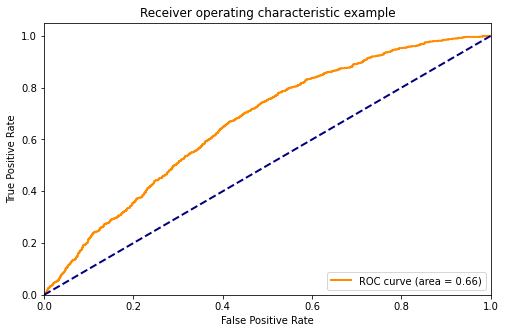

In [13]:
from pyod.models.iforest import IForest 

iforest = IForest(n_estimators=100,  max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=True, n_jobs=-1, random_state=None, verbose=0) # 初始化检测器
iforest.fit(x_train) # 使用X_train训练检测器clf

model_save_path="./model_save/"
save_path_name=model_save_path+"IForest_train_model.m"
joblib.dump(iforest,save_path_name)

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = iforest.labels_ # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)



test_y_score = iforest.decision_function(x_test)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_test, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[-0.04903367 -0.04913899 -0.05429975 ... -0.05195699 -0.05323959
 -0.02605022]
roc_auc 的值为 %s  0.6711716598040368


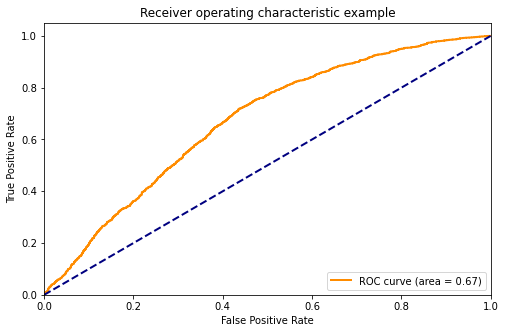

In [14]:
iforest=joblib.load(model_save_path+"IForest_train_model.m")
test_y_score = iforest.decision_function(x_train)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### MCD
The Minimum Covariance Determinant covariance estimator(MCD)将应用于高斯分布的数据，但仍可能与从单峰对称分布中得出的数据有关。

[36.95562351 22.387067   18.97044953 ... 31.5817331  14.17870194
  8.79081109]
roc_auc 的值为 %s  0.48505605636941496


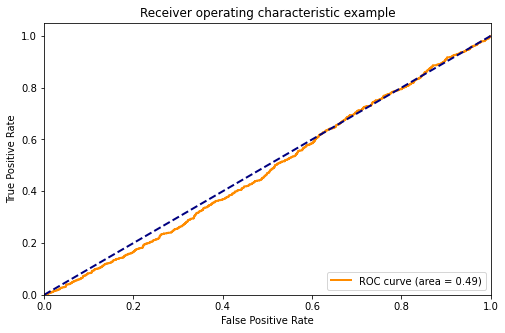

In [13]:
from pyod.models.mcd import MCD 

mcd_name="MCD"
mcd = MCD(contamination=0.1, store_precision=True, assume_centered=True, support_fraction=None, random_state=None)
# 初始化检测器
mcd.fit(x_train) # 使用X_train训练检测器clf
model_save_path="./model_save/"
save_path_name=model_save_path+"MCD_train_model.m"
joblib.dump(mcd,save_path_name)
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = mcd.labels_ # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)



test_y_score = mcd.decision_function(x_test)

print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_test, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[18.45632805 16.20571862 16.73140591 ... 10.67630164 11.86078974
 32.54805613]
roc_auc 的值为 %s  0.5049060423886109


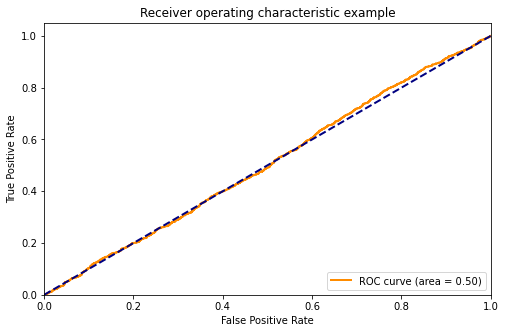

In [14]:
mcd=joblib.load(model_save_path+"MCD_train_model.m")
test_y_score = mcd.decision_function(x_train)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### PCA
PCA是线性降维，它的应用场景是对数据集进行降维。降维后的数据能够最大程度地保留原始数据的特征（以数据协方差为衡量标准）。
PCA的原理是通过构造一个新的特征空间，把原数据映射到这个新的低维空间里。PCA可以提高数据的计算性能，并且缓解"高维灾难"。


[4050.6322183  4414.17517879 4127.1474433  ... 4593.70921168 3873.75131128
 4485.67531329]
roc_auc 的值为 %s  0.6162031576355999


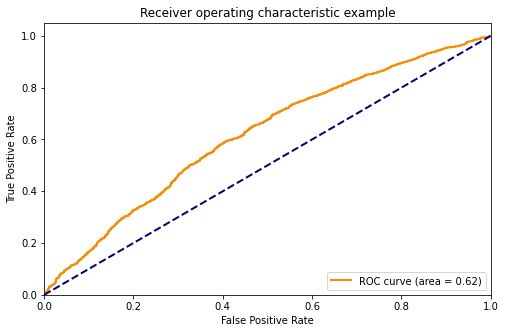

In [12]:
from pyod.models.pca import PCA 
pca=PCA(contamination=0.1)

pca.fit(x_train) # 使用X_train训练检测器clf
model_save_path="./model_save/"
save_path_name=model_save_path+"PCA_train_model.m"
joblib.dump(pca,save_path_name)
# 返回训练数据X_train上的异常标签和异常分值
#y_train_pred = hbos.labels_ # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)



test_y_score = pca.decision_function(x_train)

print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[4050.6322183  4414.17517879 4127.1474433  ... 4593.70921168 3873.75131128
 4485.67531329]
roc_auc 的值为 %s  0.6162031576355999


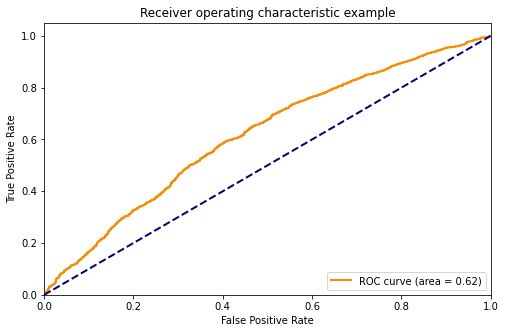

In [13]:
pca=joblib.load(model_save_path+"PCA_train_model.m")
test_y_score = pca.decision_function(x_train)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### HBOS
Histogram- based outlier detection(HBOS)是一种有效的无监督方法。 它假定特征独立，并通过构建直方图来计算异常程度。

[30.30236055 30.50868855 29.28360202 ... 32.26286907 28.96300215
 31.00551711]
roc_auc 的值为 %s  0.6592792163549686


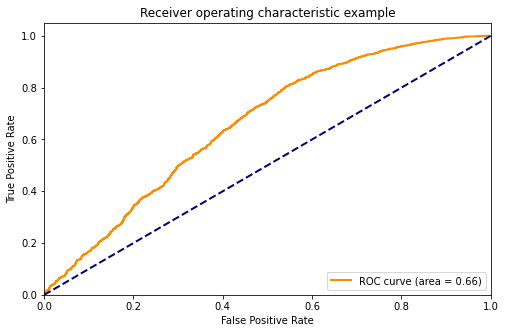

In [11]:
hbos=HBOS(contamination=0.1)

hbos.fit(x_train) # 使用X_train训练检测器clf
model_save_path="./model_save/"
save_path_name=model_save_path+"HBOS_train_model.m"
joblib.dump(hbos,save_path_name)
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = hbos.labels_ # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)



test_y_score = hbos.decision_function(x_train)

print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[30.30236055 30.50868855 29.28360202 ... 32.26286907 28.96300215
 31.00551711]
roc_auc 的值为 %s  0.6592792163549686


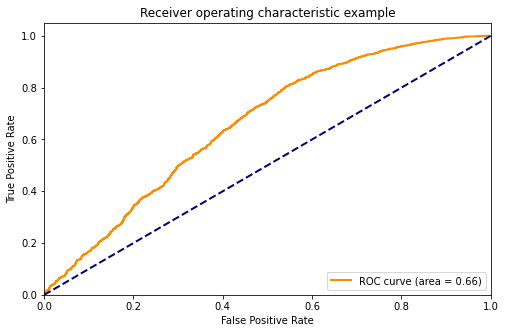

In [12]:
hbos=joblib.load(model_save_path+"HBOS_train_model.m")
test_y_score = hbos.decision_function(x_train)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### kNN
k-Nearest Neighbors Detector (kNN) ,基于kNN的离群点检测算法是一种比较简单的检测方法,定义利群因子为基于当前点到其k-最近邻邻域范围内的所有点的距离的平均值。离群因子越大，越可能是离群点。

[3.84592537e-16 2.48253415e-16 2.63312510e-16 ... 4.52041944e-16
 1.35973996e-16 1.68830575e-16]
roc_auc 的值为 %s  0.4804532262257854


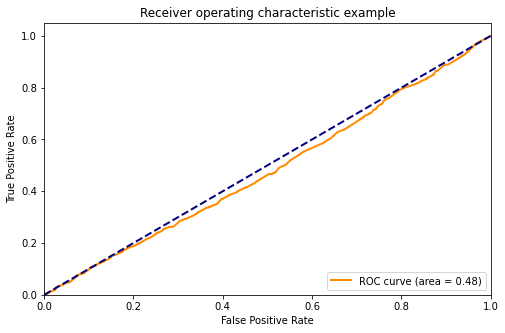

In [13]:
from pyod.models.knn import KNN # imprt kNN分类器
 
# 训练一个kNN检测器
clf_name = 'kNN'
clf = KNN(contamination=0.1 , n_neighbors=35, method='largest',radius=3.0,algorithm='auto',leaf_size=50,metric= 'minkowski',p=2,metric_params=None,n_jobs=1) # 初始化检测器
clf.fit(x_train) # 使用X_train训练检测器clf

model_save_path="./model_save/"
save_path_name=model_save_path+"KNN_train_model.m"
joblib.dump(clf,save_path_name)

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_ # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)



test_y_score = clf.decision_function(x_test)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_test, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[0. 0. 0. ... 0. 0. 0.]
roc_auc 的值为 %s  0.5


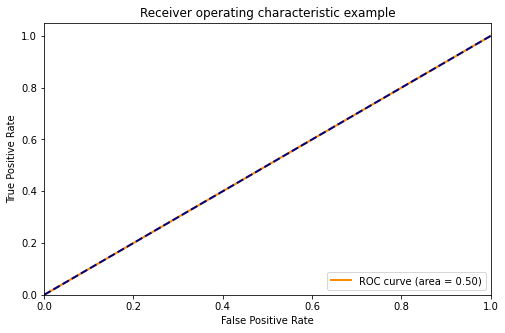

In [14]:
knn=joblib.load(model_save_path+"KNN_train_model.m")
test_y_score = knn.decision_function(x_train)
print(test_y_score)
#test_y_score[np.isnan(test_y_score)] = 0
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_train, test_y_score)  ###计算真正率和假正率
roc_auc = auc(fpr, tpr)  ###计算auc的值
print("roc_auc 的值为 %s ",roc_auc)

lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 分析
根据roc_auc值可以得到不同方法训练的模型正确率，可见，对于该数据集，kNN,MCD 方法无法取得较好的效果，在此基本上无法有效你的区分离群点。
IForest，PCA，HBOS方法能得到0.6~0.7的正确率，能较好的标记出离群点。
